In [18]:
"""pip install scikit-optimize
pip install optuna
pip install fitterpip install hyperopt
pip install lightgbm 
"""


'pip install scikit-optimize\npip install optuna\npip install fitterpip install hyperopt\npip install lightgbm \n'

In [5]:
import pandas as pd 
import numpy as np 

import multiprocessing

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, RepeatedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

# Objetivo

Comparar la tecnica de optimización ya vista RandomizedSearchCV con GridSearchCV y con Hyperopt para Python, posteriormente encontrar un modelo que pueda predecir el número de canales rechazados con los mejores hiperparámetros.

In [20]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [21]:
data1 = data.drop(["PBA", "CF", "CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO"], axis=1)

In [22]:
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


### Variable de Respuesta 

In [23]:
data1.loc[data1["Rechazados"] > 0, "Rechazados"] = 1
print(data1.Rechazados.value_counts().sort_index())

0    1329
1     585
Name: Rechazados, dtype: int64


### Correlación variables numéricas

De archivo ejecutadon con regresión se evidenció una correlación entre dos variables independientes, por lo que procederemos a eñliminar a una, la variable Ocupación

In [24]:
data1 = data1.drop(["Ocupacion"],axis=1)

### Variabes cualitativas

Eliminamos los registros de PBA2 solo quedandonos con PBA1 

In [25]:
data1 = data1.loc[data1["TIPO_CAP_CF"] != "PBA2", :]

In [26]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('Rechazados', axis = 'columns'),
                                        data1['Rechazados'],
                                        train_size   = 0.67,
                                        random_state = 1234,
                                        
                                        shuffle      = True
                                    )

## Tabla de Comparación 

In [27]:

cols = ['Técnica','knn','Ridge','LogReg', 'rforest','sgd', 'dtree',  'SVM', 'lgbm']

resul = pd.DataFrame(columns=cols)
resul.set_index("Técnica",inplace=True)
resul.loc['Standard'] = [0,0,0,0,0,0,0,0]
resul.loc['GridSearch'] = [0,0,0,0,0,0,0,0]
resul.loc['RandomSearch'] = [0,0,0,0,0,0,0,0]
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0,0,0,0,0,0,0,0
GridSearch,0,0,0,0,0,0,0,0
RandomSearch,0,0,0,0,0,0,0,0



La primera fila de nuestra tabla de resultados es el punto de partida del análisis, tomando los valores predeterminados para los hiperparámetros de cada uno de los algoritmos.

para la fila 2 tenemos los resultados del algoritmo GridSearchCV, el cual funciona probando todas las combinaciones posibles de parámetros que se desean probar en el modelo. Cada uno de esos parámetros se prueba en una serie de iteraciones de validación cruzada (Cross Validation)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

#Zona de modelos
knn = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsClassifier())])
ridge = Pipeline([('preprocessing', preprocessor),
                     ('modelo', RidgeClassifier())])
lr= Pipeline([('preprocessing', preprocessor),
                     ('modelo', LogisticRegression(solver='liblinear'))])
rf = Pipeline([('preprocessing', preprocessor),
                     ('modelo', RandomForestClassifier(n_estimators = 10))])
sgd = Pipeline([('preprocessing', preprocessor),
                     ('modelo', SGDClassifier())])
dtree = Pipeline([('preprocessing', preprocessor),
                     ('modelo', DecisionTreeClassifier())])
svc_m = Pipeline([('preprocessing', preprocessor),
                ('modelo', SVC(gamma="auto"))])
lgg = Pipeline([('preprocessing', preprocessor),
                ('modelo', lgb.LGBMClassifier())])

# Zona de parametros 
pd_knn = {
    'modelo__n_neighbors': range(1, 50, 2),
    'modelo__weights': ['uniform', 'distance'],
    'modelo__metric'   : ['euclidean', 'manhattan', 'minkowski'],
}
pd_ridge = {
    'modelo__alpha': np.logspace(-5, 5, 500),
    'modelo__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'lbfgs']}
pd_lr = {
    'modelo__solver': ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky'],
    'modelo__penalty': ['l1', 'l2', 'elasticnet'],
    'modelo__C'   : [100, 10, 1.0, 0.1, 0.01],
}
pd_rf = {
    'modelo__n_estimators': [10, 100, 1000,20000],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 500]
}
pd_sgd = {
    'modelo__loss': ['hinge', 'modified_huber', 'log'],
    'modelo__penalty': ['l1','l2'],
    'modelo__alpha': [0.0001, 0.001, 0.01, 0.1],
    'modelo__l1_ratio'   : [0.15, 0.05, .025],
    'modelo__max_iter'   : [1, 5 ,10 ,100 ,1000, 20000]
}
pd_dtree = {
    'modelo__criterion': ['gini', 'entropy', 'log_loss'],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__min_samples_split': [1, 2, 10, 50],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 500],
    'modelo__max_leaf_nodes'   : [1, 10, 20, 100, 20000],
}
pd_svc_m = {
    'modelo__C': [50, 10, 1.0, 0.1, 0.01],
    'modelo__kernel': ['poly', 'rbf', 'sigmoid'],
    'modelo__gamma' : ['scale', 'auto'],
}
pd_lgg = {
    'modelo__class_weight': [None,'balanced'],
    'modelo__boosting_type': ['gbdt', 'goss', 'dart'],
    'modelo__num_leaves' : [30,50,100,150],
    'modelo__learning_rate' : list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)),
}

# knn

### Evaluación Inicial y Búsqueda gridSearchCV

In [29]:
#Evaluación Inicial de los modelos
models = [knn,ridge,lr,rf,sgd,dtree,svc_m,lgg]

col=0
for model in models:
    model.fit(X_train,y_train.values.ravel())
    resul.iloc[0,col] = model.score(X_test,y_test)
    col += 1
resul.head()

# Resto
n_iter_    = 20
scoring_   = 'accuracy'
n_jobs_    = multiprocessing.cpu_count() - 1
cv_        = RepeatedKFold(n_splits = 5, n_repeats = 3) 

Grid_Tecn = GridSearchCV(
    estimator=knn, param_grid=pd_knn, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)

Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a1 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a1= a1.sort_values('mean_test_score', ascending = False)
a1.head(1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,param_modelo__metric,param_modelo__n_neighbors,param_modelo__weights,mean_test_score,std_test_score
81,manhattan,31,distance,0.686655,0.017361


In [30]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,0] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### Búsqueda andomizedSearchCV

In [31]:
Random_Tecn= RandomizedSearchCV(
    estimator=knn, param_distributions=pd_knn, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b1 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b1= b1.sort_values('mean_test_score', ascending = False)
b1.head(1) 


,param_modelo__weights,param_modelo__n_neighbors,param_modelo__metric,mean_test_score,std_test_score,mean_train_score,std_train_score
0,uniform,23,manhattan,0.690438,0.026846,0.714547,0.006086


In [32]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,0] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


# Ridge

### Busqueda GridSearchCV

In [33]:
Grid_Tecn = GridSearchCV(
    estimator=ridge, param_grid=pd_ridge, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a2 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a2= a2.sort_values('mean_test_score', ascending = False)
a2.head(1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
7500 fits failed out of a total of 37500.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1302, in fit
    super().fit(X, Y, sample_weight=sample_weight)
 

,param_modelo__alpha,param_modelo__solver,mean_test_score,std_test_score
1837,226.312957,cholesky,0.680446,0.029456


In [34]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,1] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### Busqueda RandomizedSearchCV

In [35]:
Random_Tecn= RandomizedSearchCV(
    estimator=ridge, param_distributions=pd_ridge, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b2 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b2= b2.sort_values('mean_test_score', ascending = False)
b2.head(1)  


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1302, in fit
    super().fit(X, Y, sample_weight=sample_weight)
  Fil

,param_modelo__solver,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
11,lsqr,18.730315,0.68261,0.029093,0.690033,0.006382


In [36]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,1] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


# Logístico

### Búsqueda GridSearchCV

In [37]:
Grid_Tecn = GridSearchCV(
    estimator=lr, param_grid=pd_lr, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a3 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a3= a3.sort_values('mean_test_score', ascending = False)
a3.head(1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, 

,param_modelo__C,param_modelo__penalty,param_modelo__solver,mean_test_score,std_test_score
50,0.01,l1,liblinear,0.678282,0.028307


In [38]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,2] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.000000,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### Búsqueda RandomizedSearchCV

In [39]:
Random_Tecn= RandomizedSearchCV(
    estimator=lr, param_distributions=pd_lr, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b3 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b3= b3.sort_values('mean_test_score', ascending = False)
b3.head(1)  

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
195 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty

,param_modelo__solver,param_modelo__penalty,param_modelo__C,mean_test_score,std_test_score,mean_train_score,std_train_score
5,newton-cg,l2,0.01,0.679094,0.017103,0.683482,0.004269


In [40]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,2] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.000000,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.000000,0.000000,0.000000,0.000000,0.00000


# Random Forest

### Búsqueda GridSearchCV

In [41]:
Grid_Tecn = GridSearchCV(
    estimator=rf, param_grid=pd_rf, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a4 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a4= a4.sort_values('mean_test_score', ascending = False)
a4.head(1)

,param_modelo__max_depth,param_modelo__max_features,param_modelo__n_estimators,mean_test_score,std_test_score
82,500,log2,1000,0.705032,0.028496


In [42]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,3] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.000000,0.000000,0.000000,0.000000,0.00000


### Búsqueda RandomizedSearchCV

In [43]:
Random_Tecn= RandomizedSearchCV(
    estimator=rf, param_distributions=pd_rf, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b4 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b4= b4.sort_values('mean_test_score', ascending = False)
b4.head(1)  

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
18,1000,auto,30,0.702062,0.035226,1.0,0.0


In [44]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,3] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.000000,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.000000,0.000000,0.000000,0.00000


# Stochastic Gradient Boosting

### Búsqueda GridSearchCV

In [45]:
Grid_Tecn = GridSearchCV(
    estimator=sgd, param_grid=pd_sgd, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a5 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a5= a5.sort_values('mean_test_score', ascending = False)
a5.head(1)

,param_modelo__alpha,param_modelo__l1_ratio,param_modelo__loss,param_modelo__max_iter,param_modelo__penalty,mean_test_score,std_test_score
419,0.1,0.025,modified_huber,20000,l2,0.686124,0.023161


In [46]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,4] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.000000,0.000000,0.000000,0.00000


### Búsqueda RandomizedSearchCV

In [47]:
Random_Tecn= RandomizedSearchCV(
    estimator=sgd, param_distributions=pd_sgd, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b5 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b5= b5.sort_values('mean_test_score', ascending = False)
b5.head(1)  

,param_modelo__penalty,param_modelo__max_iter,param_modelo__loss,param_modelo__l1_ratio,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
17,l2,100,log,0.025,0.1,0.681505,0.022203,0.683143,0.005146


In [48]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,4] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.000000,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.000000,0.000000,0.00000


# Arboles de Decisión

### Búsqueda GridSearchCV

In [49]:
Grid_Tecn = GridSearchCV(
    estimator=dtree, param_grid=pd_dtree, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a6 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a6= a6.sort_values('mean_test_score', ascending = False)
a6.head(1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
11340 fits failed out of a total of 18900.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4725 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\ProgramData\Anaconda3\lib\site

,param_modelo__criterion,param_modelo__max_depth,param_modelo__max_features,param_modelo__max_leaf_nodes,param_modelo__min_samples_split,mean_test_score,std_test_score
529,entropy,3,log2,20,2,0.67774,0.020721


In [50]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,5] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.697368,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.000000,0.000000,0.00000


### Búsqueda RandomizedSearchCV

In [51]:
Random_Tecn= RandomizedSearchCV(
    estimator=dtree, param_distributions=pd_dtree, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b6 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b6= b6.sort_values('mean_test_score', ascending = False)
b6.head(1)   

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\ProgramData\Anaconda3\lib\site-pa

,param_modelo__min_samples_split,param_modelo__max_leaf_nodes,param_modelo__max_features,param_modelo__max_depth,param_modelo__criterion,mean_test_score,std_test_score,mean_train_score,std_train_score
7,10,10,sqrt,30,gini,0.672613,0.031724,0.698407,0.009881


In [52]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,5] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.697368,0.000000,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.675987,0.000000,0.00000


# Máquinas Vectores de Soporte

### Búsqueda GridSearchCV

In [53]:
Grid_Tecn = GridSearchCV(
    estimator=svc_m, param_grid=pd_svc_m, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a7 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a7= a7.sort_values('mean_test_score', ascending = False)
a7.head(1)

,param_modelo__C,param_modelo__gamma,param_modelo__kernel,mean_test_score,std_test_score
13,1.0,scale,rbf,0.686106,0.028502


In [54]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,6] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.697368,0.738487,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.675987,0.000000,0.00000


### Búsqueda RandomizedSearchCV

In [55]:
Random_Tecn= RandomizedSearchCV(
    estimator=svc_m, param_distributions=pd_svc_m, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b7 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b7= b7.sort_values('mean_test_score', ascending = False)
b7.head(1)    

,param_modelo__kernel,param_modelo__gamma,param_modelo__C,mean_test_score,std_test_score,mean_train_score,std_train_score
19,rbf,scale,0.01,0.678257,0.038261,0.67828,0.009558


In [56]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,6] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.71875
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.697368,0.738487,0.00000
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.675987,0.694079,0.00000


# LGBM

### Búsqueda GridSearchCV

In [57]:
Grid_Tecn = GridSearchCV(
    estimator=lgg, param_grid=pd_lgg, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a8 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a8= a8.sort_values('mean_test_score', ascending = False)
a8.head(1)

,param_modelo__boosting_type,param_modelo__class_weight,param_modelo__learning_rate,param_modelo__num_leaves,mean_test_score,std_test_score
24,gbdt,None,0.05848,30,0.69262,0.022865


In [58]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,7] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()


,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.718750
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.697368,0.738487,0.740132
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.675987,0.694079,0.000000


### Búsqueda RandomizedSearchCV

In [59]:
Random_Tecn= RandomizedSearchCV(
    estimator=lgg, param_distributions=pd_lgg, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b8 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b8= b8.sort_values('mean_test_score', ascending = False)
b8.head(1)   

,param_modelo__num_leaves,param_modelo__learning_rate,param_modelo__class_weight,param_modelo__boosting_type,mean_test_score,std_test_score,mean_train_score,std_train_score
13,30,0.038815,None,gbdt,0.695053,0.026632,0.963127,0.006114


In [60]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,7] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.718750
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.697368,0.738487,0.740132
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.675987,0.694079,0.730263


## Stacking

In [61]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingClassifier

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe_knn = Pipeline([('preprocessing', preprocessor),
                     ('knn', KNeighborsClassifier(weights='distance',n_neighbors=19, metric='manhattan'))])
pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', RidgeClassifier(solver='auto',alpha=31.11))])
pipe_lr= Pipeline([('preprocessing', preprocessor),
                     ('Poisson', LogisticRegression(solver='liblinear',penalty='l2',C=1))])
pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestClassifier(
                                         n_estimators = 10000,
                                         max_features = 'log2',
                                         max_depth    = 100
                                        )
                     )])
pipe_sgd = Pipeline([('preprocessing', preprocessor),
                     ('Gradient_Boosting_Trees',SGDClassifier(
                                         penalty = 'l2',                 
                                         alpha= 0.1,
                                         loss = 'modified_huber',
                                         max_iter  = 10,
                                         l1_ratio= 0.05
                                        )
                     )])
pipe_dtree = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', DecisionTreeClassifier(
                                         min_samples_split = 2,                 
                                         max_leaf_nodes = 10,
                                         max_features = 'log2',
                                         max_depth    = 3,
                                         criterion = 'entropy'
                                        )
                     )])
pipe_svm = Pipeline([('preprocessing', preprocessor),
                     ('svm', SVC(
                                         C = 1,                 
                                         kernel = 'rbf',
                                         gamma  = 'scale'
                                        )
                     )])
pipe_lgbm = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', lgb.LGBMClassifier(
                                         num_leaves= 30,                 
                                         learning_rate= 0.038815,
                                         class_weight= None,
                                         boosting_type= 'gbdt',
                                        )
                     )])

In [62]:
# Definición y entrenamiento del StackingRegressor
# ==============================================================================
estimators = [('random_forest', pipe_rf),
              ('KNN', pipe_knn),
              ('DLGBM', pipe_lgbm),
              ('svm', pipe_svm)]

stacking_cla= StackingClassifier(estimators=estimators,
                                       final_estimator=LogisticRegression())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_cla.fit(X = X_train, y = y_train)

In [63]:
stacking_model = stacking_cla
predicciones7 = stacking_model.predict(X = X_test)

Accuracy_stacking= accuracy_score(y_true  = y_test, y_pred  = predicciones7)
print(f"Accuracy: {Accuracy_stacking}")


Accuracy: 0.7549342105263158


In [64]:
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,lgbm
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.685855,0.652961,0.649671,0.717105,0.718750
GridSearch,0.717105,0.703947,0.694079,0.753289,0.713816,0.697368,0.738487,0.740132
RandomSearch,0.702303,0.712171,0.705592,0.753289,0.705592,0.675987,0.694079,0.730263


Text(0.5, 0, 'Test accuracy')

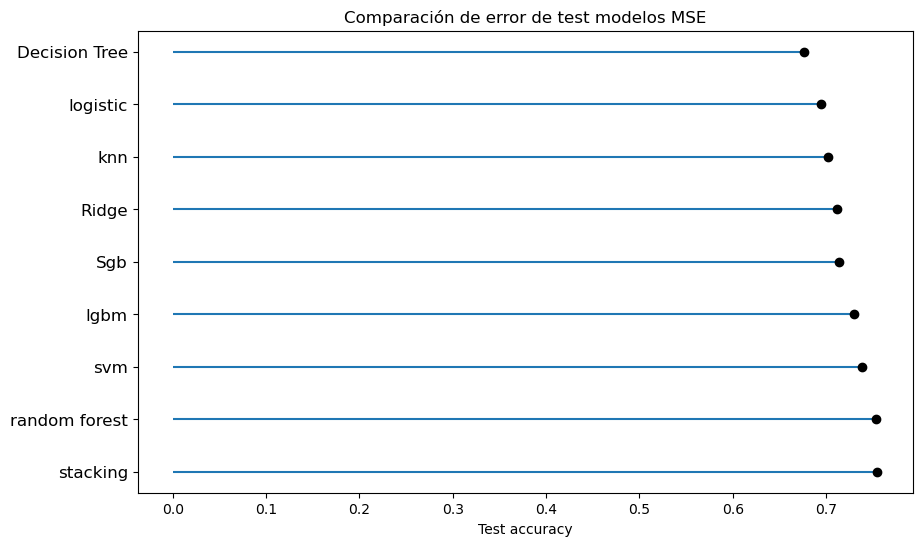

In [65]:
error_modelos = pd.DataFrame({'modelo': ['knn', 'Ridge','logistic' ,'random forest', 'Sgb',"Decision Tree", "svm", 'lgbm','stacking'],
                              'Accuracy': [resul.iloc[2,0], resul.iloc[2,1], resul.iloc[1,2], resul.iloc[2,3], resul.iloc[1,4], resul.iloc[2,5],resul.iloc[1,6], resul.iloc[2,7] ,Accuracy_stacking]})
error_modelos = error_modelos.sort_values('Accuracy', ascending=False)


plt.figure(figsize=(10, 6))
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.Accuracy)
plt.plot(error_modelos.Accuracy, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación de error de test modelos MSE')
plt.xlabel('Test accuracy')

